In [159]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [183]:
# Negative Sample
neg_sample_visibility = pd.read_csv('../data/processed/neg_sample_visibility.csv', index_col=[0])
neg_sample_temperature = pd.read_csv('../data/processed/neg_sample_temperature.csv', index_col=[0])
neg_sample_precipitation = pd.read_csv('../data/processed/neg_sample_precipitation.csv', index_col=[0])
negative_sample = pd.read_csv('../data/processed/negative_sample.csv', index_col=[0])

# Positive sample
pos_sample_visibility = pd.read_csv('../data/processed/pos_sample_visibility.csv', index_col=[0])
pos_sample_temperature = pd.read_csv('../data/processed/pos_sample_temperature.csv', index_col=[0])
pos_sample_precipitation = pd.read_csv('../data/processed/pos_sample_precipitation.csv', index_col=[0])
positive_sample = pd.read_csv('../data/processed/positive_sample.csv', index_col=[0])
pos_sample_precipitation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52118 entries, 0 to 107727
Data columns (total 7 columns):
year             52118 non-null int64
month            52118 non-null int64
weekday          52118 non-null int64
hour             52118 non-null int64
segment_id       52118 non-null float64
prec_duration    52118 non-null float64
prec_height      52118 non-null float64
dtypes: float64(3), int64(4)
memory usage: 3.2 MB


In [184]:
# Merge (we need to reset index of precipitation df)
negative_sample['humidity'], negative_sample['temparature'], negative_sample['visibility'],negative_sample['prec_height'],negative_sample['prec_duration']  =  neg_sample_temperature['humidity'], neg_sample_temperature['temperature'], neg_sample_visibility['visibility'],neg_sample_precipitation.reset_index()['prec_height'],neg_sample_precipitation.reset_index()['prec_duration'] 
positive_sample['humidity'], positive_sample['temparature'], positive_sample['visibility'],positive_sample['prec_height'],positive_sample['prec_duration']  =  pos_sample_temperature['humidity'], pos_sample_temperature['temperature'], pos_sample_visibility['visibility'],pos_sample_precipitation.reset_index()['prec_height'],pos_sample_precipitation.reset_index()['prec_duration'] 

full_data = negative_sample.append(positive_sample)


c:\users\bened\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [185]:
# FUll DATA
full_data = full_data[[
    'segment_id',
    'year',
    'month_cos',
    'month_sin',
    'weekday',
    'hour_cos',
    'hour_sin',
    'collision_cnt',
    'side_strt',
    'sun_elevation_angle',
    'humidity',
    'temparature',
    'visibility',
    'prec_height',
    'prec_duration',
    'collision'
]]

full_data['collision_cnt'] = full_data['collision_cnt'].fillna(0)

full_data = full_data.round(3)

#full_data['weekday'] = full_data['weekday'].astype('category')

full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312820 entries, 0 to 52117
Data columns (total 16 columns):
segment_id             312820 non-null float64
year                   312820 non-null int64
month_cos              312820 non-null float64
month_sin              312820 non-null float64
weekday                312820 non-null int64
hour_cos               312820 non-null float64
hour_sin               312820 non-null float64
collision_cnt          312820 non-null float64
side_strt              312820 non-null float64
sun_elevation_angle    312820 non-null float64
humidity               312820 non-null float64
temparature            312820 non-null float64
visibility             312820 non-null float64
prec_height            312820 non-null float64
prec_duration          312820 non-null float64
collision              312820 non-null int64
dtypes: float64(13), int64(3)
memory usage: 40.6 MB


In [186]:
# Split
X_train = full_data[full_data['year'] < 2020].drop(['collision','segment_id'],axis=1)
X_test = full_data[full_data['year'] == 2020].drop(['collision','segment_id'],axis=1)

y_train = full_data[full_data['year'] < 2020]['collision']
y_test = full_data[full_data['year'] == 2020]['collision']

In [187]:
y_train.value_counts()

0    174119
1     36227
Name: collision, dtype: int64

In [188]:
# Random Forest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

num_pipe = SimpleImputer(strategy="mean", add_indicator=True)
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(
        n_estimators=70
    )
)

In [189]:
cv_result = cross_validate(rf_clf, X_train, y_train, scoring="roc_auc", cv=5)

In [190]:
cv_result['test_score'].mean()

0.8526879330941084

In [191]:
rf_clf.fit(X_train, y_train).steps[1][1].feature_importances_

array([0.00518885, 0.0064924 , 0.00668809, 0.08503517, 0.02692091,
       0.02343244, 0.39658446, 0.05556772, 0.24381687, 0.04447277,
       0.03689854, 0.01881553, 0.02370778, 0.02637848])

Text(0, 0.5, 'Mean decrease in impurity')

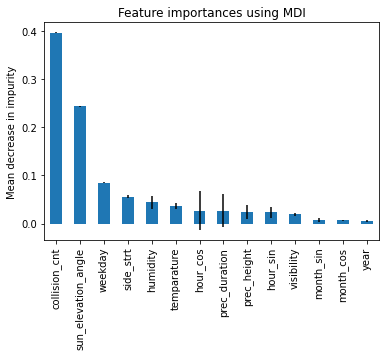

In [192]:
# Plot Feature Importance for baseline RF model

import time
import numpy as np

forest_importances = pd.Series(rf_clf.steps[1][1].feature_importances_, index=rf_clf.feature_names_in_)

start_time = time.time()
importances = rf_clf.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.steps[1][1].estimators_], axis=0)
elapsed_time = time.time() - start_time

fig, ax = plt.subplots()
forest_importances.sort_values(axis=0, ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [1]:
## RANDOM PARAMETER GRID SEARCH
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 401, 100)]
# Number of features to consider at every split
max_features = ['log2','sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 51, 10)]
max_depth.append(None)

criterion = ['gini', 'entropy']
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion':criterion}

print(random_grid)

{'n_estimators': [200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 383, 385, 387, 389, 391, 393, 395, 397, 400], 'max_features': ['log2', 'sqrt'], 'max_depth': [30, 32, 34, 36, 38, 41, 43, 45, 47, 50, None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'bootstrap': [False], 'criterion': ['gini', 'entropy']}


In [254]:
rf_random = GridSearchCV(estimator = RandomForestClassifier(), 
                               param_grid = random_grid,
                               scoring='roc_auc',
                               cv = 3, 
                               verbose=2, 
                               n_jobs = -1,
                               return_train_score = True)

In [255]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [30, 35, 40, 45, 50, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 6, 11, 16],
                         'min_samples_split': [2, 5, 8, 12],
                         'n_estimators': [250, 261, 272, 283, 294, 305, 316,
                                          327, 338, 350]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [256]:
rf_random.best_score_

0.8956388086414308

In [257]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 45,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 327}

In [ ]:
brf_random = GridSearchCV(estimator = BalancedRandomForestClassifier(), 
                               param_grid = random_grid,
                               scoring='roc_auc',
                               cv = 3, 
                               verbose=2, 
                               n_jobs = -1,
                               return_train_score = True)

In [ ]:
brf_random.fit(X_train, y_train)

In [ ]:
brf_random.best_score_

In [ ]:
brf_random.best_params_

In [2]:
#Random Forest with oversampling using SMOTE and undersampling using RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

from collections import Counter

# summarize class distribution - highly imbalanced dataset
counter = Counter(y_train)
print(counter)


## RANDOM PARAMETER GRID SEARCH
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

over_n = [float(x) for x in np.arange(0.25, 0.351, 0.10)]
# RandomUnderSampler undersampling
under_n = [float(x) for x in np.arange(0.35, 0.451, 0.10)]

# Create the random grid
random_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap,
               'randomforestclassifier__criterion':criterion,
              'smote__sampling_strategy':over_n,
              'randomundersampler__sampling_strategy':under_n}

print(random_grid)

NameError: name 'y_train' is not defined

In [ ]:
# define pipeline
# oversample positive (minority) to be x% the number of negative (majority)
over = SMOTE(sampling_strategy = 0.1)
# randomly undersample negative (majority) to reduce the number of negative to x% of the positive (minority)
under = RandomUnderSampler(sampling_strategy = 0.25) 

pipeline = make_pipeline(over, under, RandomForestClassifier(n_estimators = 260,
 min_samples_split =2,
 min_samples_leaf=1,
 max_features= 'auto',
 max_depth= 90,
 bootstrap= False))

rf_sampling_random = GridSearchCV(pipeline,
                               param_grid = random_grid,
                               scoring='roc_auc',
                               cv = 3, 
                               verbose=2, 
                               n_jobs = -1,
                               return_train_score = True)

In [ ]:
rf_sampling_random.fit(X_train,y_train)
rf_sampling_random.best_score_


In [ ]:
rf_sampling_random.best_params_

In [472]:
# BALANCED BAGGING

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 301, num = 5)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

over_n = [float(x) for x in np.arange(0.1, 0.351, 0.05)]
# RandomUnderSampler undersampling
under_n = [float(x) for x in np.arange(0.35, 0.51, 0.05)]

# Create the random grid
bb_random_grid = {'balancedbaggingclassifier__n_estimators': n_estimators,
                 'balancedbaggingclassifier__bootstrap': bootstrap,
                 'smote__sampling_strategy':over_n,
              'randomundersampler__sampling_strategy':under_n}


# define pipeline
# oversample positive (minority) to be x% the number of negative (majority)
over = SMOTE(sampling_strategy = 0.1)
# randomly undersample negative (majority) to reduce the number of negative to x% of the positive (minority)
under = RandomUnderSampler(sampling_strategy = 0.25) 

pipeline = make_pipeline(over, under, BalancedBaggingClassifier(base_estimator=HistGradientBoostingClassifier(random_state=42)))

In [473]:
bb_random = GridSearchCV(estimator = pipeline, 
                               param_grid = bb_random_grid,
                               scoring='roc_auc',
                               cv = 3, 
                               verbose=2, 
                               n_jobs = -1,
                               return_train_score = True)

In [250]:
bb_random.fit(X_train, y_train)
bb_random.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


0.8569596662369879

In [234]:
bb_random.best_params_

{'n_estimators': 207, 'bootstrap': True}

In [106]:
# LOGISTIC REGRESSION
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate



num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_linear = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))
lr_clf.set_params(logisticregression__class_weight="balanced")

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=2,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017D03FB0988>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_col

In [107]:
cv_result = cross_validate(lr_clf, X_train, y_train, scoring="roc_auc", cv=5)

In [108]:
cv_result['test_score'].mean()

0.896134662615431

In [477]:
# Support Vector Classification with RandomOverSampling
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline 

num_pipe = make_pipeline(
    MinMaxScaler(feature_range=(0, 1))
)
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_svc = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

smote = SMOTE(sampling_strategy=0.1)

rus = RandomUnderSampler(sampling_strategy=0.2)

svc_clf = make_pipeline(preprocessor_svc, smote, rus, SVC(kernel='rbf',C=1))

In [478]:
cv_result = cross_validate(svc_clf, X_train, y_train, scoring="roc_auc", cv=5)

In [479]:
cv_result['test_score'].mean()

0.8430180789451789

In [482]:
parameters = {'smote__sampling_strategy':[float(x) for x in np.arange(0.1, 0.351, 0.05)],
              'randomundersampler__sampling_strategy':[float(x) for x in np.arange(0.35, 0.51, 0.05)],
              'svc__kernel':('linear', 'rbf', 'poly'), 
              'svc__C':[1,10,100,1000],
              'svc__gamma':[1,0.1,0.001,0.0001], 
              'svc__degree':[1,2]}

svc_grid = GridSearchCV(svc_clf, parameters, scoring="roc_auc", cv=3)

In [483]:
svc_grid.fit(X_train, y_train)
svc_grid.best_score_

KeyboardInterrupt: 

In [445]:
svc_grid.best_params_

{'rus__sampling_strategy': 0.2,
 'smote__sampling_strategy': 0.1,
 'svc__C': 1,
 'svc__class_weight': None,
 'svc__degree': 2,
 'svc__kernel': 'rbf'}